# Подключение библиотек, описание глобальных переменных

In [291]:
import torch
import torch.nn as nn
from torch.optim import (
    SGD, 
    RMSprop, 
    Adam
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss
)

import numpy as np
import requests
import pandas as pd

import plotly.graph_objs as go

import warnings
warnings.filterwarnings('ignore')

In [292]:
LR = 0.1
MOMENTUM = 0.8
EPOCHS = 1000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Загрузка данных

In [293]:
data = requests.get('https://raw.githubusercontent.com/sikoraaxd/Homework/main/datasets/bioresponce.csv').content
with open('data.csv', 'wb') as f:
  f.write(data)

df = pd.read_csv('data.csv')
df

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3746,1,0.033300,0.506409,0.10,0.0,0.209887,0.633426,0.297659,0.376124,0.727093,...,0,0,0,0,0,0,0,0,0,0
3747,1,0.133333,0.651023,0.15,0.0,0.151154,0.766505,0.170876,0.404546,0.787935,...,0,0,1,0,1,0,1,0,0,0
3748,0,0.200000,0.520564,0.00,0.0,0.179949,0.768785,0.177341,0.471179,0.872241,...,0,0,0,0,0,0,0,0,0,0
3749,1,0.100000,0.765646,0.00,0.0,0.536954,0.634936,0.342713,0.447162,0.672689,...,0,0,0,0,0,0,0,0,0,0


# Разделение данных на тренировочную и тестовую выборки, перевод данных в тензоры

In [294]:
X, y = df.iloc[:, 1:].values, df.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.6, 
                                                    shuffle=True)

In [295]:
X_train = torch.tensor(X_train).to(torch.float32)
X_test = torch.tensor(X_test).to(torch.float32)
y_train = torch.tensor(y_train).to(torch.float32)
y_test = torch.tensor(y_test).to(torch.float32)

# Описание сети

In [296]:
class Net(nn.Module):
  def __init__(self, in_features):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(in_features, 32),
        nn.Linear(32, 16),
        nn.Linear(16, 10),
        nn.Linear(10, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.model(x)


# Вспомогательные фунции

In [297]:
def train(model, optimizer, loss_fn, X, y, silent=False):
  loss_data = []

  for epoch in range(EPOCHS):
    optimizer.zero_grad()
    pred = model(X)
    loss = loss_fn(torch.squeeze(pred), y)
    loss_data.append(loss.detach().numpy())
    if epoch and epoch % (EPOCHS/10) == 0 and not silent:
      print(f'Эпоха: {epoch}, Ошибка: {loss}')
    loss.backward()
    optimizer.step()

  return model, loss_data


# Обучение сети

In [298]:
model = Net(X_train.shape[1]).to(device)
optimizer = SGD(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

sgd_model, sgd_loss_data = train(model, optimizer, loss_fn, X_train, y_train)

Эпоха: 100, Ошибка: 0.23518462479114532
Эпоха: 200, Ошибка: 0.1907586008310318
Эпоха: 300, Ошибка: 0.15184548497200012
Эпоха: 400, Ошибка: 0.1342734843492508
Эпоха: 500, Ошибка: 0.1412656009197235
Эпоха: 600, Ошибка: 0.13472095131874084
Эпоха: 700, Ошибка: 0.1306746006011963
Эпоха: 800, Ошибка: 0.12737199664115906
Эпоха: 900, Ошибка: 0.12455033510923386


In [299]:
model = Net(X_train.shape[1]).to(device)
optimizer = SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
loss_fn = nn.MSELoss()

momentum_model, momentum_loss_data = train(model, optimizer, loss_fn, X_train, y_train)

Эпоха: 100, Ошибка: 0.13306908309459686
Эпоха: 200, Ошибка: 0.10910985618829727
Эпоха: 300, Ошибка: 0.09466367214918137
Эпоха: 400, Ошибка: 0.090219646692276
Эпоха: 500, Ошибка: 0.08334609121084213
Эпоха: 600, Ошибка: 0.09861785918474197
Эпоха: 700, Ошибка: 0.08066049218177795
Эпоха: 800, Ошибка: 0.1276533603668213
Эпоха: 900, Ошибка: 0.0929943174123764


In [300]:
model = Net(X_train.shape[1]).to(device)
optimizer = RMSprop(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

rmsprop_model, rmsprop_loss_data = train(model, optimizer, loss_fn, X_train, y_train)

Эпоха: 100, Ошибка: 0.46133333444595337
Эпоха: 200, Ошибка: 0.46133333444595337
Эпоха: 300, Ошибка: 0.46133333444595337
Эпоха: 400, Ошибка: 0.46133333444595337
Эпоха: 500, Ошибка: 0.46133333444595337
Эпоха: 600, Ошибка: 0.46133333444595337
Эпоха: 700, Ошибка: 0.46133333444595337
Эпоха: 800, Ошибка: 0.46133333444595337
Эпоха: 900, Ошибка: 0.46133333444595337


In [301]:
model = Net(X_train.shape[1]).to(device)
optimizer = Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

adam_model, adam_loss_data = train(model, optimizer, loss_fn, X_train, y_train)

Эпоха: 100, Ошибка: 0.46133333444595337
Эпоха: 200, Ошибка: 0.46133333444595337
Эпоха: 300, Ошибка: 0.46133333444595337
Эпоха: 400, Ошибка: 0.46133333444595337
Эпоха: 500, Ошибка: 0.46133333444595337
Эпоха: 600, Ошибка: 0.46133333444595337
Эпоха: 700, Ошибка: 0.46133333444595337
Эпоха: 800, Ошибка: 0.46133333444595337
Эпоха: 900, Ошибка: 0.46133333444595337


# Визуализация обучения сети

In [302]:
fig = go.Figure()
names = ['Стохастический градиентный спуск',
         'Метод моментов',
         'RMSProp',
         'Adam']
for i, data in enumerate([sgd_loss_data, 
                          momentum_loss_data, 
                          rmsprop_loss_data, 
                          adam_loss_data]):
  fig.add_trace(go.Scatter(x=np.arange(EPOCHS), y=data, name=names[i]))

fig.update_layout(
    xaxis_title='Эпохи',
    yaxis_title='Ошибка'
)

fig.show()

Обучение сети при learning rate = 0.01
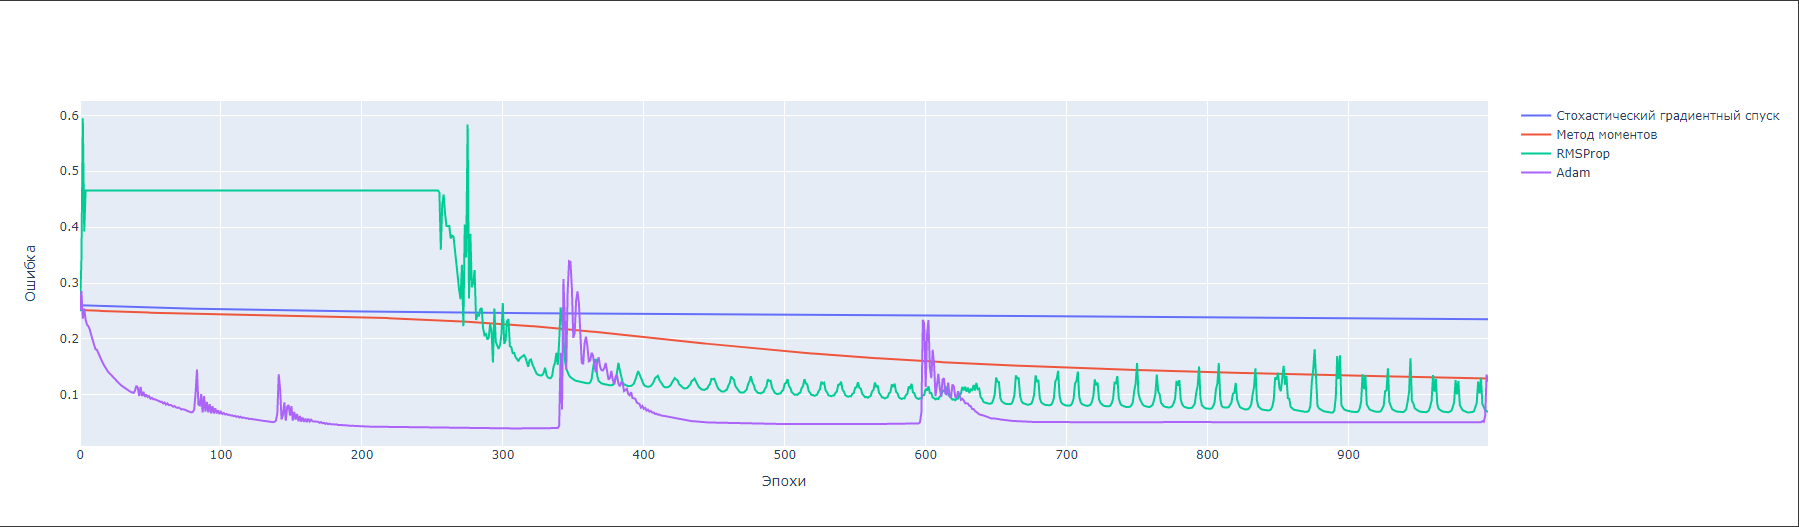

# Сравнительный анализ качества обученных сетей

In [303]:
metrics = []
y_test = y_test.detach().numpy()

for model in [sgd_model,
              momentum_model,
              rmsprop_model,
              adam_model]:

  predict = np.round(model(X_test).detach().numpy())
  accuracy  = accuracy_score(y_test, predict)
  precision = precision_score(y_test, predict)
  recall    = recall_score(y_test, predict)
  f1        = f1_score(y_test, predict)
  logl      = log_loss(y_test, predict)

  metrics.append([accuracy, precision, recall, f1, logl])

In [266]:
data = {
    'SGD': metrics[0],
    'Momentum': metrics[1],
    'RMSProp': metrics[2],
    'Adam': metrics[3]
}

data_df = pd.DataFrame(data, index=['Accuracy', 
                                    'Precision', 
                                    'Recall', 
                                    'F1-Score', 
                                    'Log Loss'])
data_df

,SGD,Momentum,RMSProp,Adam
Accuracy,0.723518,0.716855,0.480346,0.519654
Precision,0.684904,0.717791,0.000000,0.519654
Recall,0.866667,0.750000,0.000000,1.000000
F1-Score,0.765139,0.733542,0.000000,0.683911
Log Loss,4.407788,4.514000,8.284517,7.657868


# Поиск лучшего значения learning rate для двух лучших моделей: с методом моментов и Adam

In [271]:
learning_rate = 1e-8

adam_accuracy_data = []
momentum_accuracy_data = []

while learning_rate < 1:

  adam_model = Net(X_train.shape[1]).to(device)
  optimizer = Adam(adam_model.parameters(), lr=learning_rate)
  loss_fn = nn.MSELoss()

  adam_model, _ = train(adam_model, 
                        optimizer, 
                        loss_fn, 
                        X_train,
                        y_train,
                        silent=True)

  with torch.no_grad():
    predict =  np.round(adam_model(X_test))
    accuracy = accuracy_score(y_test, predict)
    adam_accuracy_data.append([learning_rate, accuracy])


  momentum_model = Net(X_train.shape[1]).to(device)
  optimizer = SGD(momentum_model.parameters(), lr=learning_rate, momentum=MOMENTUM)
  loss_fn = nn.MSELoss()

  momentum_model, _ = train(momentum_model, 
                            optimizer, 
                            loss_fn, 
                            X_train, 
                            y_train,
                            silent=True)

  with torch.no_grad():
    predict =  np.round(momentum_model(X_test))
    accuracy = accuracy_score(y_test, predict)
    momentum_accuracy_data.append([learning_rate, accuracy])

  learning_rate *= 10

In [289]:
adam_accuracy_data = np.array(adam_accuracy_data)
momentum_accuracy_data = np.array(momentum_accuracy_data)

In [290]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=adam_accuracy_data[:, 0], y=adam_accuracy_data[:, 1], name='Adam'))
fig.add_trace(go.Scatter(x=momentum_accuracy_data[:, 0], y=momentum_accuracy_data[:, 1], name='Метод моментов'))

fig.update_layout(
    xaxis_title='learning rate',
    yaxis_title='accuracy'
)

fig.show()